In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import re
from typing import Optional
from nerfstudio.cameras.rays import RaySamples, Frustums
from nerfstudio.cameras.cameras import Cameras, CameraType

from reni.configs.reni_config import RENIField
from reni.configs.sh_sg_envmap_configs import SHField, SGField
from reni.pipelines.reni_pipeline import RENIPipeline
from reni.field_components.field_heads import RENIFieldHeadNames
from reni.data.datamanagers.reni_datamanager import RENIDataManager
from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.utils.colourspace import linear_to_sRGB

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

def load_model(load_dir: Path, load_step: Optional[int] = None, eval_rotation: Optional[int] = None):
    ckpt_dir = load_dir / 'nerfstudio_models'
    def clean_and_load_yaml(yaml_content):
        # Remove !!python related tags
        cleaned_content = re.sub(r'!!python[^\s]*', '', yaml_content)
        
        # Load the cleaned content
        return yaml.safe_load(cleaned_content)

    if load_step is None:
        load_step = sorted(int(x[x.find("-") + 1 : x.find(".")]) for x in os.listdir(ckpt_dir))[-1]
    
    ckpt = torch.load(ckpt_dir / f'step-{load_step:09d}.ckpt', map_location=device)
    reni_model_dict = {}
    for key in ckpt['pipeline'].keys():
        if key.startswith('_model.'):
            reni_model_dict[key[7:]] = ckpt['pipeline'][key]
    
    config_path = load_dir / 'config.yml'
    with open(config_path, 'r') as f:
        content = f.read()
        config = clean_and_load_yaml(content)
    
    if 'latent_dim' in config['pipeline']['model']['field'].keys():
        
        model_config = RENIField.config
        model_config.pipeline.datamanager.dataparser.convert_to_ldr = config['pipeline']['datamanager']['dataparser']['convert_to_ldr']
        model_config.pipeline.datamanager.dataparser.convert_to_log_domain = config['pipeline']['datamanager']['dataparser']['convert_to_log_domain']
        if config['pipeline']['datamanager']['dataparser']['eval_mask_path'] is not None:
            eval_mask_path = Path(os.path.join(*config['pipeline']['datamanager']['dataparser']['eval_mask_path']))
            model_config.pipeline.datamanager.dataparser.eval_mask_path = eval_mask_path
        else:
            model_config.pipeline.datamanager.dataparser.eval_mask_path = None
        if config['pipeline']['datamanager']['dataparser']['min_max_normalize'].__class__ == list:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = tuple(config['pipeline']['datamanager']['dataparser']['min_max_normalize'])
        else:
            model_config.pipeline.datamanager.dataparser.min_max_normalize = config['pipeline']['datamanager']['dataparser']['min_max_normalize']
        model_config.pipeline.datamanager.dataparser.augment_with_mirror = config['pipeline']['datamanager']['dataparser']['augment_with_mirror']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
        model_config.pipeline.model.field.conditioning = config['pipeline']['model']['field']['conditioning']
        model_config.pipeline.model.field.invariant_function = config['pipeline']['model']['field']['invariant_function']
        model_config.pipeline.model.field.equivariance = config['pipeline']['model']['field']['equivariance']
        model_config.pipeline.model.field.axis_of_invariance = config['pipeline']['model']['field']['axis_of_invariance']
        model_config.pipeline.model.field.positional_encoding = config['pipeline']['model']['field']['positional_encoding']
        model_config.pipeline.model.field.encoded_input = config['pipeline']['model']['field']['encoded_input']
        model_config.pipeline.model.field.latent_dim = config['pipeline']['model']['field']['latent_dim']
        model_config.pipeline.model.field.hidden_features = config['pipeline']['model']['field']['hidden_features']
        model_config.pipeline.model.field.hidden_layers = config['pipeline']['model']['field']['hidden_layers']
        model_config.pipeline.model.field.mapping_layers = config['pipeline']['model']['field']['mapping_layers']
        model_config.pipeline.model.field.mapping_features = config['pipeline']['model']['field']['mapping_features']
        model_config.pipeline.model.field.num_attention_heads = config['pipeline']['model']['field']['num_attention_heads']
        model_config.pipeline.model.field.num_attention_layers = config['pipeline']['model']['field']['num_attention_layers']
        model_config.pipeline.model.field.output_activation = config['pipeline']['model']['field']['output_activation']
        model_config.pipeline.model.field.last_layer_linear = config['pipeline']['model']['field']['last_layer_linear']
        model_config.pipeline.model.field.trainable_scale = config['pipeline']['model']['field']['trainable_scale']
        model_config.pipeline.model.field.old_implementation = config['pipeline']['model']['field']['old_implementation']
        model_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
    elif 'spherical_harmonic_order' in config['pipeline']['model']['field'].keys():
        model_config = SHField.config
        model_config.pipeline.model.field.spherical_harmonic_order = config['pipeline']['model']['field']['spherical_harmonic_order']
    elif 'row_col_gaussian_dims' in config['pipeline']['model']['field'].keys():
        model_config = SGField.config
        model_config.pipeline.model.field.row_col_gaussian_dims = config['pipeline']['model']['field']['row_col_gaussian_dims']

    if eval_rotation is not None:
        model_config.pipeline.datamanager.dataparser.apply_eval_rotation = eval_rotation

    pipeline: RENIPipeline = model_config.pipeline.setup(
      device=device,
      test_mode=test_mode,
      world_size=world_size,
      local_rank=local_rank,
      grad_scaler=None,
    )

    datamanager = pipeline.datamanager

    model = pipeline.model

    model.to(device)
    model.load_state_dict(reni_model_dict)
    model.eval()

    return pipeline, datamanager, model


def get_latents(model_path, rotations):
    model_latents = {}
    
    for rotation in rotations:
        pipeline, datamanager, model = load_model(Path(model_path), eval_rotation=rotation)

        metrics_dict = pipeline.get_average_eval_image_metrics(optimise_latents=True)
        latents = model.field.eval_mu

        model_latents[rotation] = latents
    
    return model_latents

In [2]:
model_path = '/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100'
rotations = [0, 5, 20, 45, 90, 180, 270]

model_latents = get_latents(model_path, rotations)

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

Output()

Output()

/home/user/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming
release, it will be required to pass the indexing argument. (Triggered internally at 
../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

/home/user/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing 
`spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import 
`spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

Output()

Output()

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

Output()

Output()

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

Output()

Output()

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

Output()

Output()

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

Output()

Output()

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

Output()

Output()

In [6]:
import roma

def compute_relative_error_per_image(Z1, Z2):
    # Assuming Z1 and Z2 are of shape [latent_dim, 3] for a single image
    Z1 = Z1.float()
    Z2 = Z2.float()

    M = torch.linalg.lstsq(Z1, Z2).solution
    R = roma.special_procrustes(M)
    E = (torch.norm(Z1 @ R - Z2) / torch.norm(Z2)).item()

    return E

def compute_mean_error_for_rotations(reference_latents, latent_dict):
    errors = {}
    for rotation, latents in latent_dict.items():
        if rotation == 0:  # Skip the reference rotation
            continue
        # Compute errors for each image separately
        errors_for_rotation = []
        for i in range(latents.size(0)):
            error = compute_relative_error_per_image(reference_latents[i], latents[i])
            errors_for_rotation.append(error)
        # Average the errors across all images for this rotation
        mean_error = torch.tensor(errors_for_rotation).mean().item()
        std_error = torch.tensor(errors_for_rotation).std().item()
        errors[rotation] = [mean_error, std_error]
    return errors


mean_errors = compute_mean_error_for_rotations(model_latents[0], model_latents)
for rotation, errors in mean_errors.items():
    print(f"Rotation {rotation}: {errors[0]:.3f} +/- {errors[1]:.3f}")



Rotation 5: 0.959 +/- 0.088
Rotation 20: 0.965 +/- 0.110
Rotation 45: 0.955 +/- 0.093
Rotation 90: 0.941 +/- 0.105
Rotation 180: 0.957 +/- 0.108
Rotation 270: 0.956 +/- 0.100


In [17]:
from reni.utils.colourspace import linear_to_sRGB

pipeline, datamanager, model = load_model(Path(model_path), eval_rotation=90)


Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

TypeError: RENIModel.create_ray_samples() missing 2 required positional arguments: 'directions' and 'camera_indices'

In [19]:

idx, ray_bundle, batch = datamanager.next_eval_image(0)

ray_samples = model.create_ray_samples(directions=ray_bundle.directions, camera_indices=ray_bundle.camera_indices, origins=ray_bundle.origins)

latent = model_latents[90][idx] # shape [latent_dim, 3]

latent = latent.unsqueeze(0).repeat(ray_samples.shape[0], 1, 1)

model_outputs = model.field(ray_samples=ray_samples, latent_codes=latent)

In [27]:
from reni.field_components.field_heads import RENIFieldHeadNames

rgb = model_outputs[RENIFieldHeadNames.RGB]

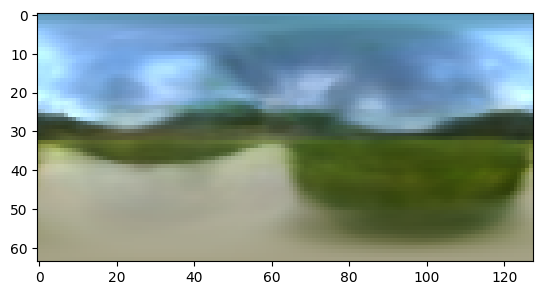

In [30]:
plt.imshow(linear_to_sRGB(torch.exp(rgb), use_quantile=True).reshape(64, 128, 3).cpu().detach().numpy())

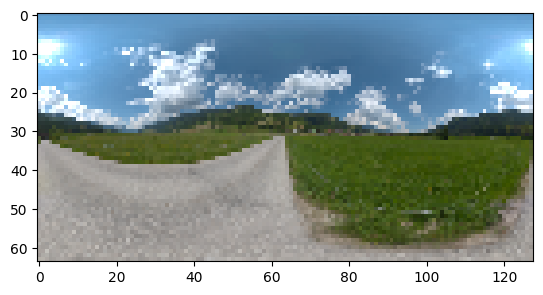

In [31]:
plt.imshow(linear_to_sRGB(torch.exp(batch['image']), use_quantile=True).reshape(64, 128, 3).cpu().detach().numpy())